# Scraping Sonntagsfrage (Allensbach) 

## 1. Get an understanding of the website

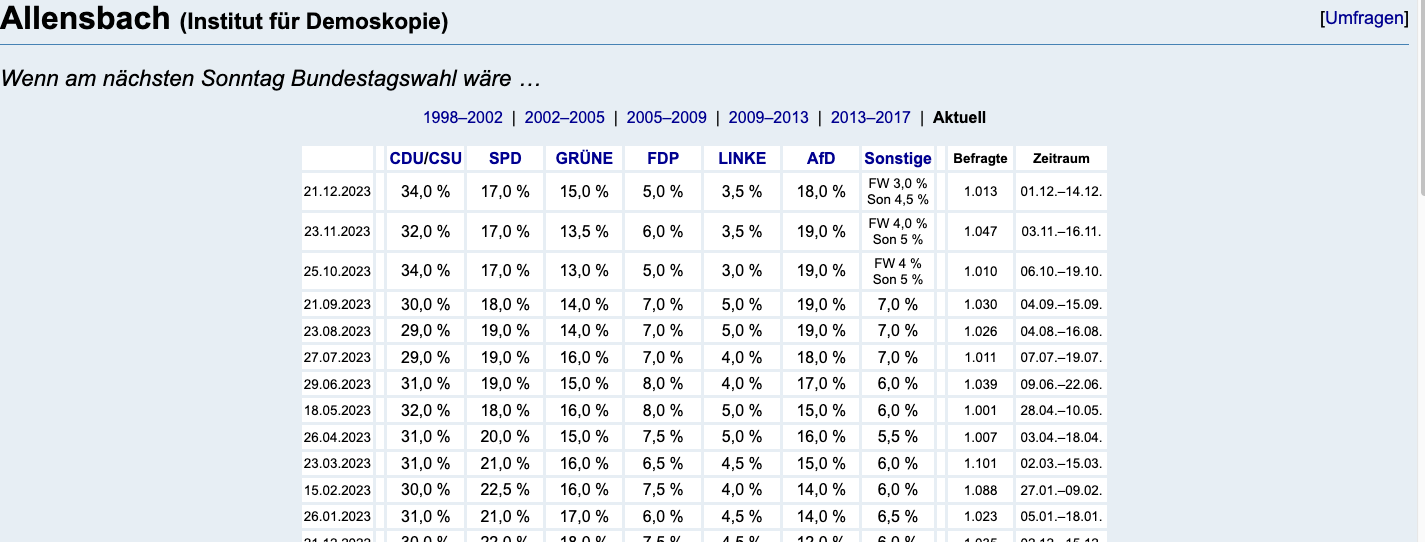

## 2. Understanding the data structure 

In [2]:
# import packages 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Get html file 
html = requests.get('https://www.wahlrecht.de/umfragen/allensbach.htm') 
doc = BeautifulSoup(html.text, "html5lib")

In [5]:
# Understanding the structure where the column names are
doc.find_all("tr")[1]

<tr>
 <th class="dat"> </th>
 <th> </th>
 <th class="part"><a href="#fn-cdu">CDU</a>/<a href="#fn-csu">CSU</a></th>
 <th class="part"><a href="#fn-spd">SPD</a></th>
 <th class="part"><a href="#fn-gru">GRÜNE</a></th>
 <th class="part"><a href="#fn-fdp">FDP</a></th>
 <th class="part"><a href="#fn-lin">LINKE</a></th>
 <th class="part"><a href="#fn-afd">AfD</a></th>
 <th><a href="#fn-son">Sonstige</a></th>
 <th> </th>
 <th class="befr">Befragte</th>
 <th class="dat2">Zeitraum</th>
</tr>

In [6]:
# Understanding the structure where the survey results are
doc.find_all("tr")[5]

<tr>
 <td class="s">21.12.2023</td>
 <td> </td>
 <td>34,0 %</td>
 <td>17,0 %</td>
 <td>15,0 %</td>
 <td>5,0 %</td>
 <td>3,5 %</td>
 <td>18,0 %</td>
 <td class="s">FW 3,0 %<br/>Son 4,5 %</td>
 <td> </td>
 <td class="s">1.013</td>
 <td class="s">01.12.–14.12.</td>
</tr>

In [10]:
# General idea 
infos = doc.find_all("tr")[5].find_all("td")
test = [th.get_text().strip() for th in infos if th.get_text().strip()] # ZENTRAL CHECKE SOLCHE ABFRAGEN
row = pd.DataFrame(test).T
row

,0,1,2,3,4,5,6,7,8,9
0,21.12.2023,"34,0 %","17,0 %","15,0 %","5,0 %","3,5 %","18,0 %","FW 3,0 %Son 4,5 %",1.013,01.12.–14.12.


## 3. Get the data

In [12]:
# Get the names of columns 

column_name_part = doc.find_all("tr")[1].find_all('th')
cols = [th.get_text().strip() for th in column_name_part if th.get_text().strip()]
columnn_names = ["Release_date"] + cols # Problem one column has no name: Release date


# Empty list for surveys
rows = []

# Get all survey results 
all_surveys = doc.find_all("tr")[5:]
for survey in all_surveys: 
    one = survey.find_all("td")
    results = [th.get_text().strip() for th in one if th.get_text().strip()]
    row = pd.DataFrame(results).T
    if "Bundestagswahl" in row.values: 
        row["9"] = "Bundestagswahl"
    row.columns = columnn_names
    rows.append(row) 
data = pd.concat(rows, axis = 0)

  
pd.concat([data.head(1), data.sample(n = 3), data.tail(1)], axis = 0)

,Release_date,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Befragte,Zeitraum
0,21.12.2023,"34,0 %","17,0 %","15,0 %","5,0 %","3,5 %","18,0 %","FW 3,0 %Son 4,5 %",1.013,01.12.–14.12.
0,23.02.2018,"32,0 %","17,5 %","12,0 %","11,0 %","9,5 %","13,0 %","5,0 %",1.271,02.02.–15.02.
0,25.02.2021,"37,0 %","15,0 %","20,0 %","7,0 %","7,0 %","9,5 %","4,5 %",1.082,04.02.–17.02.
0,21.09.2023,"30,0 %","18,0 %","14,0 %","7,0 %","5,0 %","19,0 %","7,0 %",1.030,04.09.–15.09.
0,24.09.2017,"32,9 %","20,5 %","8,9 %","10,7 %","9,2 %","12,6 %","5,0 %",Bundestagswahl,Bundestagswahl


## 4. Data prepartion 

In [14]:
cols = data.columns[1:-3]
data["Release_date"] = pd.to_datetime(data['Release_date'], format='%d.%m.%Y')

# Remove "%" 
for column in cols: 
    data[column] = data[column].str.replace("%", "")

for column in cols: 
    data[column] = data[column].str.replace(",", ".")

for column in cols: 
    data[column] = data[column].astype("float")

# Melt dataframe 
df = data.iloc[:, 0:-3]
melted_df = pd.melt(df, id_vars=["Release_date"], value_vars=df.columns)

## 5. Data visualization 

<function matplotlib.pyplot.show(close=None, block=None)>

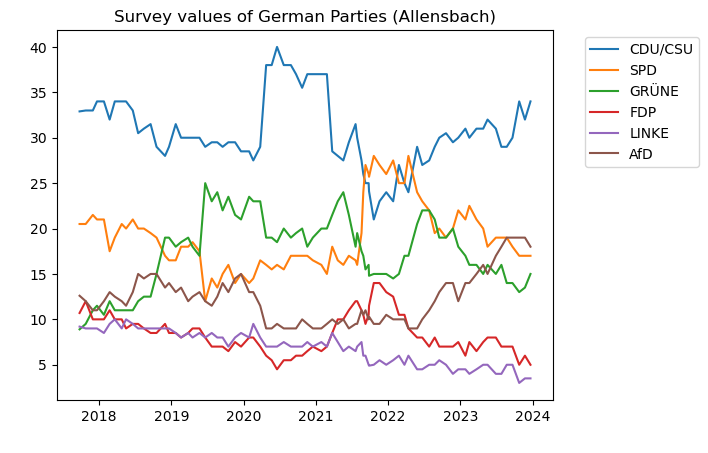

In [15]:
sns.lineplot(x = "Release_date", y = "value", hue = "variable", data = melted_df)
plt.ylabel(" ")
plt.xlabel(" ") 
plt.title("Survey values of German Parties (Allensbach)") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show